<Figure size 864x576 with 0 Axes>

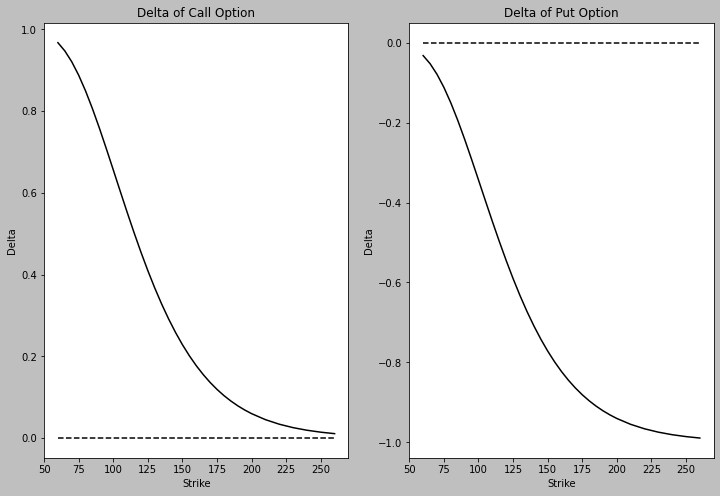

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from pathlib import Path

plt.style.use('grayscale')
plt.figure(figsize=(12, 8))

df = pd.read_csv('AAPL_option_2023-06-15.csv', index_col=0)
c = df.loc[df['Contract Name'].str.contains('C')]
p = df.loc[df['Contract Name'].str.contains('P')]

s0 = 100  # close price of aapl on June 1 2021
sigma = 0.25  # estimate of annual volatility
T = 2  # roughly 2 years from now
r = 0.04  # 1 Yr Treasury Yield Curve Rates
K = c['Strike']  # strike of call is identical to put in this case
d1 = (np.log(s0/K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
delta_c = norm.cdf(d1)
delta_p = -norm.cdf(-d1)
gamma = norm.pdf(d1) / (s0 * sigma * np.sqrt(T))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Delta of Call Option")
plt.xlabel("Strike")
plt.ylabel("Delta")
plt.plot(K, delta_c)
plt.hlines(0, K.iloc[0], K.iloc[-1], linestyles='dashed')

plt.subplot(1, 2, 2)
plt.title("Delta of Put Option")
plt.xlabel("Strike")
plt.ylabel("Delta")
plt.plot(K, delta_p)
plt.hlines(0, K.iloc[0], K.iloc[-1], linestyles='dashed')
plt.savefig('call_put_delta.png')

In [53]:
import numpy as np
import pandas as pd
from pandas_datareader import data

spy_close = data.get_data_yahoo('SPY', start='2000-03-01', end='2021-02-28').loc[:, 'Adj Close']
spy_close.name = 'SPY'
spy_ret = (np.log(spy_close) - np.log(spy_close.shift(1))).dropna()
vix_close = data.get_data_yahoo('^VIX', start='2000-03-01', end='2021-02-28').loc[:, 'Adj Close']
vix_close.name = 'VIX'

real_vol = spy_ret.rolling(window=30).std() * np.sqrt(252)
merged_df = real_vol.to_frame().join(vix_close).dropna()
merged_df

,SPY,VIX
Date,,
2000-04-12,0.245818,28.980000
2000-04-13,0.250098,29.400000
2000-04-14,0.299815,33.490002
2000-04-17,0.315617,28.950001
2000-04-18,0.318356,26.120001
...,...,...
2021-02-22,0.140984,23.450001
2021-02-23,0.140202,23.110001
2021-02-24,0.141580,21.340000


In [54]:
type(merged_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [10]:
real_vol = merged_df.loc[:, 'SPY']
implied_vol = merged_df.loc[:, 'VIX'] / 100
premium = implied_vol - real_vol
premium.describe()

count    5252.000000
mean        0.033098
std         0.052010
min        -0.436174
25%         0.014654
50%         0.037550
75%         0.059326
max         0.243735
dtype: float64

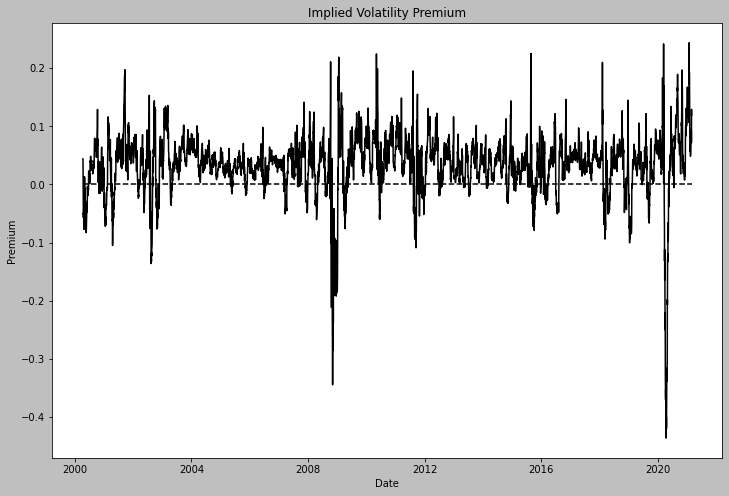

In [18]:
plt.figure(figsize=(12, 8))

plt.title("Implied Volatility Premium")
plt.xlabel("Date")
plt.ylabel("Premium")

plt.plot(premium)
plt.hlines(0, premium.index[0], premium.index[-1], linestyles='dashed')

plt.savefig('implied_rlzd_premium.png')

In [52]:
premium

NameError: name 'premium' is not defined

In [45]:
import numpy as np

s0 = 125  # inital asset price
t = 1  # maturity in years
r = 0.05  # annual risk free rate
sigma = .25  # annual volatility
n = 252  # number of steps in unit of t
N = 100000  # number of random draws
k = 125  # at-the money option

def bs_simulate(s0, t, r, sigma, n, N):
    dt = 1 / n
    dwt = np.random.normal(0, np.sqrt(dt), (N, int(n * t)))
    s = np.zeros((N, dwt.shape[1] + 1))
    s[:, 0] = s0
    for i in range(1, s.shape[1]):
        s[:, i] = s[:, i-1] + s[:, i-1] * r * \
            dt + s[:, i-1] * sigma * dwt[:, i-1]
    return s

def lookback_price(k, t, is_call, paths):
    s_m = np.max(paths, axis=1) if is_call else np.min(paths, axis=1)
    return np.fmax(s_m - k, 0) if is_call else np.fmax(k - s_m, 0)

def c(s0=s0, sigma=sigma, t=t, r=r, k=k, n=n, N=N):
    np.random.seed(0)  # to get the same random numbers every time
    paths = bs_simulate(s0, t, r, sigma, n, N)
    look_prc = np.exp(-r * t) * np.mean(lookback_price(k, t, True, paths))
    return look_prc

epsilon = 1e-6  # different epsilon gets different gamma
delta = (c(s0+epsilon) - c(s0-epsilon)) / (2*epsilon)  # 1.1608790693173887
vega = (c(s0, sigma+epsilon) - c(s0, sigma-epsilon)) / (2*epsilon)  # 106.27836798526857

In [46]:
delta, vega

(1.1619823290232034, 106.48038839811136)

In [96]:
import numpy as np
import math

s0 = 125
t = 1.0
r = 0.05
nu0 = .3**2
n = 252
N = 10000
xi = 0.75
rho = 0.9
kappa = 1
theta = nu0
k = s0*math.exp(r*t)  # at-the-money option

def heston_simulate(s0, t, r, nu0, kappa, theta, xi, rho, n, N):
    dt = 1 / n
    dwt = np.random.multivariate_normal(
        mean=(0, 0),
        cov=[[dt, rho*dt], [rho*dt, dt]],
        size=(N, int(n * t)))
    s, nu = np.zeros((N, dwt.shape[1] + 1)), np.zeros((N, dwt.shape[1] + 1))
    s[:, 0], nu[:, 0] = s0, nu0
    for i in range(1, s.shape[1]):
        s[:, i] = s[:, i-1] + s[:, i-1] * r * dt \
            + s[:, i-1] * nu[:, i-1]**0.5 * dwt[:, i-1, 0]
        nu[:, i] = nu[:, i-1] + kappa*(theta-nu[:, i-1]) \
            + xi*nu[:, i-1]**0.5*dwt[:, i-1, 1]
    s = s
    nu = nu
    return s, nu

def euro_payoffs(k, t, is_call, paths):
    st = paths[:, -1]
    return np.fmax(st - k, 0) if is_call else np.fmax(k - st, 0)

def c(s0=s0, nu0=nu0, theta=theta, t=t, r=r, kappa=kappa, xi=xi, rho=rho, n=n, N=N, k=k):
    np.random.seed(0)  # to get the same random numbers every time
    pathsS0, pathsNu = heston_simulate(s0, t, r, nu0, kappa, theta, xi, rho, n, N)
    euro_prc = np.exp(-r * t) * np.mean(euro_payoffs(k, t, True, pathsS0))
    return euro_prc

dnu0_delta = (xi * rho * epsilon) / s0

sigma = np.sqrt(nu0)
d1 = (np.log(s0/k) + (r + 0.5*sigma**2) * t) / (sigma * np.sqrt(t))
bs_delta = norm.cdf(d1)

epsilon = 1e-6
heston_delta = (c(s0=s0+epsilon, nu0=nu0) - c(s0=s0-epsilon, nu0=nu0)) / (2*epsilon)  # 0.6303207156221902
smile_delta = (c(s0=s0+epsilon, nu0=nu0+dnu0_delta) - c(s0=s0-epsilon, nu0=nu0-dnu0_delta)) / (2*epsilon)  # 0.6303207156221902

In [97]:
bs_delta, heston_delta, smile_delta, s0

(0.5596176923702424, 0.5553720869855283, 0.5566823091385231, 125)

In [ ]:
dSt = sigma_t St dW_1
dSigma_t^2 = psi sigma_t dW_2

E[dW_1 dW_2] = rho dt

epsilon = sigma_t St dW_1
dW_1 = epsilon / (sigma_t St)

dW_2 = rho dW_1

dSigma_t^2 = psi sigma_t dW_2
dSigma_t^2 = psi sigma_t rho dW_1
dSigma_t^2 = psi sigma_t rho epsilon / (sigma_t St)
dSigma_t^2 = psi rho epsilon / (St)

In [ ]:
dF_t = sigma_t F_t^B dW_1
dsigma_t = alpha sigma_t dW_2

eps = sigma_t F_t^B dW_1
dW_1 = eps / (sigma_t F_t^B)

dW_2 = rho dW_1

dsigma_t =  alpha sigma_t dW_2
dsigma_t =  alpha sigma_t rho dW_1
dsigma_t =  alpha rho eps / (F_t^B)

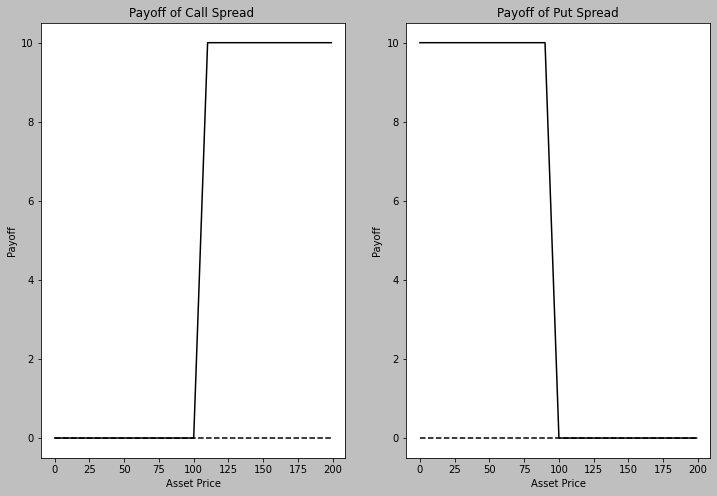

In [39]:
import matplotlib.pyplot as plt

x = np.arange(0, 200, 1)
k = 100
h = 10

s = x
c_k = np.maximum(s - k, 0)
p_k = np.maximum(k - s, 0)
c_kph = np.maximum(s - (k + h), 0)
c_kp2h = np.maximum(s - (k + 2*h), 0)
c_kmh = np.maximum(s - (k - h), 0)
p_kph = np.maximum((k + h) - s, 0)
p_kmh = np.maximum((k - h) - s, 0)

plt.style.use('grayscale')

plt.figure(figsize=(12, 8))

# call spread 
plt.subplot(1, 2, 1)
payoff_call_spread = c_k - c_kph
plt.title("Payoff of Call Spread ")
plt.xlabel("Asset Price")
plt.ylabel("Payoff")
plt.plot(x, payoff_call_spread)
plt.hlines(0, x[0], x[-1], linestyles='dashed')

# put spread 
plt.subplot(1, 2, 2)
payoff_put_spread = p_k - p_kmh
plt.title("Payoff of Put Spread")
plt.xlabel("Asset Price")
plt.ylabel("Payoff")
plt.plot(x, payoff_put_spread)
plt.hlines(0, x[0], x[-1], linestyles='dashed')
plt.savefig('payoff_call_put_spread.png')

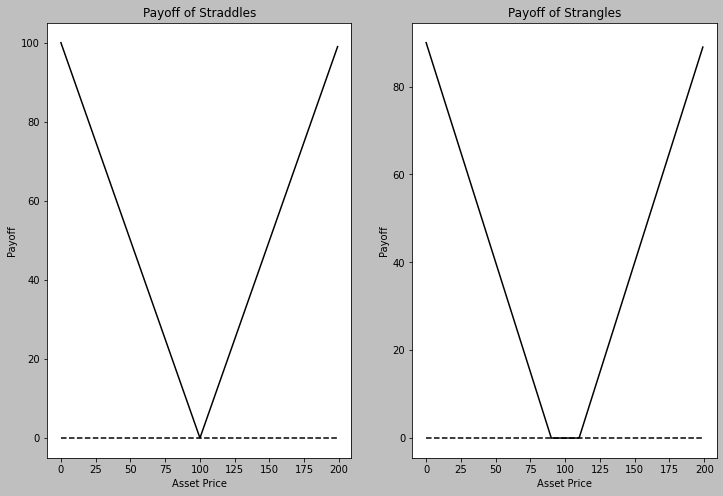

In [40]:
plt.figure(figsize=(12, 8))

# straddles 
plt.subplot(1, 2, 1)
payoff_staddles = p_k + c_k
plt.title("Payoff of Straddles")
plt.xlabel("Asset Price")
plt.ylabel("Payoff")
plt.plot(x, payoff_staddles)
plt.hlines(0, x[0], x[-1], linestyles='dashed')

# strangles 
plt.subplot(1, 2, 2)
payoff_strangles = p_kmh + c_kph
plt.title("Payoff of Strangles")
plt.xlabel("Asset Price")
plt.ylabel("Payoff")
plt.plot(x, payoff_strangles)
plt.hlines(0, x[0], x[-1], linestyles='dashed')
plt.savefig('payoff_straddles_strangles.png')

In [60]:
s0, K

(125, 156.25)

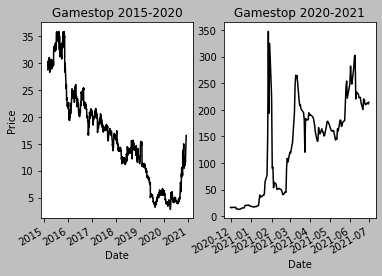

In [114]:
gme_before_close = data.get_data_yahoo('GME', start='2015-03-01', end='2020-11-30').loc[:, 'Adj Close']
gme_during_close = data.get_data_yahoo('GME', start='2020-11-30', end='2021-06-30').loc[:, 'Adj Close']

plt.style.use('grayscale')

plt.subplot(1, 2, 1)
plt.title("Gamestop 2015-2020")
plt.xlabel("Date")
plt.ylabel("Price")
gme_before_close.plot()

plt.subplot(1, 2, 2)
plt.title("Gamestop 2020-2021")
plt.xlabel("Date")
gme_during_close.plot()

plt.savefig('gme_time_series_charts.png')
plt.show()

<AxesSubplot:xlabel='Date'>

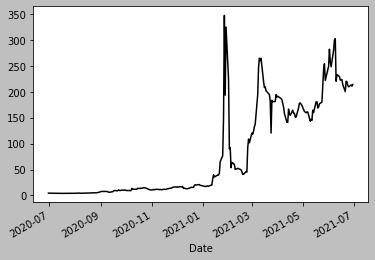